# 1. Environment Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install pandas numpy tqdm matplotlib seaborn scikit-learn scikeras tensorflow keras keras-tuner scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.7 MB/s eta 0:00:00


In [ ]:
# Data Manipulation
import pandas as pd
import re
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Deep Learning
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from tensorflow.keras.layers import Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPooling1D

## 1.1 Data Imports

In [ ]:
# Import Data
df = pd.read_csv('/content/drive/MyDrive/maastricht.csv')

# Separate features (X) and target variable (y)
X = df.drop('precipitation', axis=1)
y = df['precipitation']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for LSTM (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train, axis=1)  # Add timestep dimension
X_test_reshaped = np.expand_dims(X_test, axis=1)

# 2. Base Model (LSTM)
Below is a simple LSTM learning model. This will give us a great place to start from and will serve as our baseline for future performances.

## 2.1 Structure

1. **First LSTM Layer:**
   - 64 units with `relu` activation to capture complex temporal patterns.
   - `return_sequences=True` allows this layer to pass the full sequence output to the next LSTM layer.

2. **Dropout Layer:**
   - Prevents overfitting by randomly setting 20% of inputs to zero during training.

3. **Second LSTM Layer:**
   - 32 units with `relu` activation and `return_sequences=True` for passing the sequence to the next layer.

4. **Another Dropout Layer:**
   - Adds additional regularization to the model.

5. **Third LSTM Layer:**
   - 16 units with `relu` activation. This layer does not return sequences, as it's the last LSTM layer before the Dense output layer.

6. **Dense Output Layer:**
   - A single neuron to predict the target variable (precipitation).

In [ ]:
# Define the LSTM model with 3-4 layers
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.2518 - val_loss: 0.1583
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1464 - val_loss: 0.1656
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1336 - val_loss: 0.1546
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1349 - val_loss: 0.1549
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1630 - val_loss: 0.1485
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1591 - val_loss: 0.1517
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1621 - val_loss: 0.1522
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1430 - val_loss: 0.1446
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1447 - val_loss: 0.1521
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1436 - val_loss: 0.1419


## 2.2 Performance

Plotting the performance (training and validation loss) over epochs helps visualize the learning process of the model. It shows whether the model is learning effectively or if adjustments are needed. By observing these plots, you can identify whether the model is converging, overfitting, or underfitting.

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


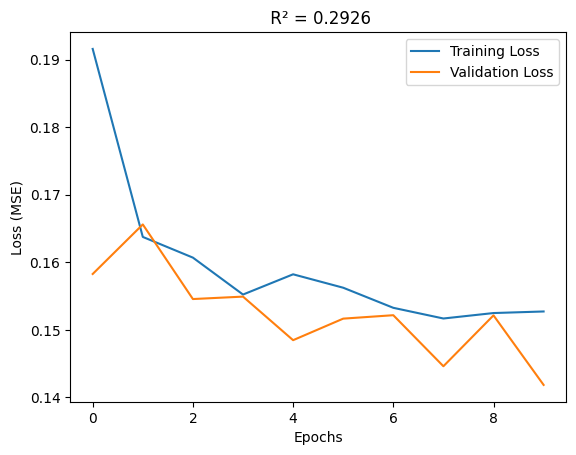

In [ ]:
def plot_model_results(history, model, X_test, y_test, title=""):
    """
    Plots training and validation loss over epochs and calculates R² score.

    Parameters:
    - history: History object from model training.
    - model: Trained model for making predictions.
    - X_test: Test features for prediction.
    - y_test: True values for R² calculation.
    - title: Custom title for each subplot
    """

    # Get training and validation loss from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Make predictions on the test set and flatten predictions
    y_pred = model.predict(X_test).flatten()

    # Calculate the R² score
    r2 = r2_score(y_test, y_pred)

    # Plot training and validation loss over epochs
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f"{title} R² = {r2:.4f}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()

plot_model_results(history, model, X_test_reshaped, y_test)

# 3. Scaling Data


## **Standardization Scaler (Z-Score Normalization)**

- *What It Does*: Centers the data around the mean and scales it according to the standard deviation, resulting in a distribution with a mean of 0 and a standard deviation of 1.
- *How It Works*: Each value is transformed using: $(x - \text{mean}) / \text{std deviation}$.
- *When to Use*: Preferred when the data does not have a fixed range or when it follows a normal distribution.
- *Why*: Standardization ensures that features are centered and scaled, improving the performance of algorithms like linear regression and clustering, which assume normally distributed data.

In [ ]:
X = df.drop('precipitation', axis=1)
y = df['precipitation']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using MinMaxScaler
scaler = StandardScaler()

# Fit the scaler on training data and transform both training and testing sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train_scaled, axis=1)  # Add timestep dimension
X_test_reshaped = np.expand_dims(X_test_scaled, axis=1)

In [ ]:
# Define the LSTM model with 3-4 layers
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.2266 - val_loss: 0.1401
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1315 - val_loss: 0.1191
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1073 - val_loss: 0.1119
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1243 - val_loss: 0.1036
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0986 - val_loss: 0.1115
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1116 - val_loss: 0.1066
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1208 - val_loss: 0.1050
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0942 - val_loss: 0.1035
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1060 - val_loss: 0.1034
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1151 - val_loss: 0.1026


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


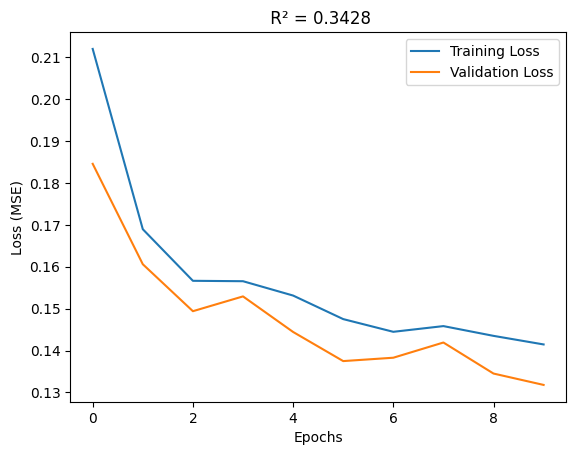

In [ ]:
plot_model_results(history, model, X_test_reshaped, y_test)

## **MinMax Scaler**

- *What It Does*: Scales the features to a fixed range, typically between 0 and 1.
- *How It Works*: Transforms each feature by subtracting the minimum value and dividing by the range (max - min).
- *When to Use*: Useful when the data has a known minimum and maximum, or when you want to maintain zero-centered data but within a specific range.
- *Why*: It preserves the relationships between values while ensuring all features are on the same scale, which can be important for models sensitive to feature magnitudes (e.g., neural networks).

In [ ]:
X = df.drop('precipitation', axis=1)
y = df['precipitation']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on training data and transform both training and testing sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train_scaled, axis=1)  # Add timestep dimension
X_test_reshaped = np.expand_dims(X_test_scaled, axis=1)

In [ ]:
# Define the LSTM model with 3-4 layers
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - loss: 0.2230 - val_loss: 0.1846
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2037 - val_loss: 0.1606
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1542 - val_loss: 0.1494
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1821 - val_loss: 0.1529
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1420 - val_loss: 0.1444
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1747 - val_loss: 0.1375
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1455 - val_loss: 0.1383
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1306 - val_loss: 0.1419
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1369 - val_loss: 0.1345
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1415 - val_loss: 0.1318


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


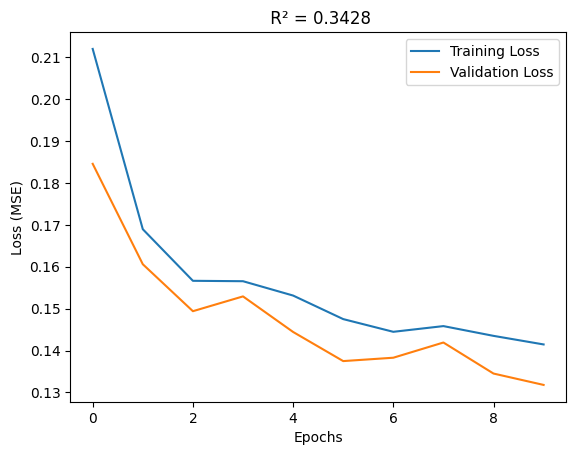

In [ ]:
plot_model_results(history, model, X_test_reshaped, y_test)

# 4. Increase Epochs

Let's see if the downward loss trend continues

In [ ]:
X = df.drop('precipitation', axis=1)
y = df['precipitation']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using MinMaxScaler
scaler = StandardScaler()

# Fit the scaler on training data and transform both training and testing sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train_scaled, axis=1)  # Add timestep dimension
X_test_reshaped = np.expand_dims(X_test_scaled, axis=1)

In [ ]:
# Define the LSTM model with 3-4 layers
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.2459 - val_loss: 0.1512
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1595 - val_loss: 0.1230
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1281 - val_loss: 0.1175
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1276 - val_loss: 0.1074
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1087 - val_loss: 0.1041
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1067 - val_loss: 0.1025
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1155 - val_loss: 0.1029
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1283 - val_loss: 0.1021
Epoch 9/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1134 - val_loss: 0.1050
Epoch 10/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1095 - val_loss: 0.1017
Epoch 11/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1034 - val_loss: 0.1025
Epoch 12/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0971 - val_loss: 0.1029

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


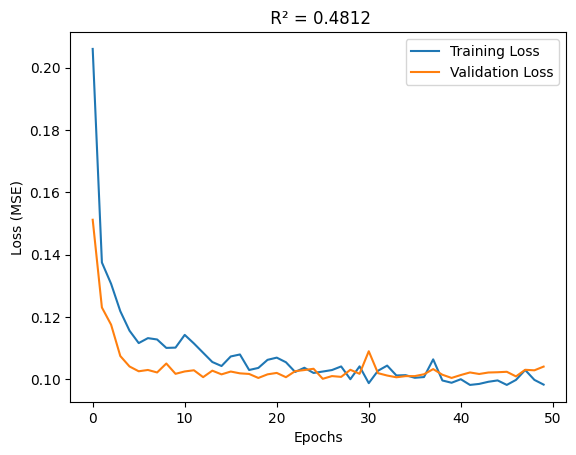

In [ ]:
plot_model_results(history, model, X_test_reshaped, y_test)

#5. Adjust Learning Rate

Our learning curve seems a little jagged - let's see if adjustments to our learning rate can smooth things over.

Epoch 1/75


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.2390 - val_loss: 0.2467
Epoch 2/75
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2297 - val_loss: 0.2422
Epoch 3/75
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2518 - val_loss: 0.2377
Epoch 4/75
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2390 - val_loss: 0.2328
Epoch 5/75
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2311 - val_loss: 0.2274
Epoch 6/75
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1948 - val_loss: 0.2209
Epoch 7/75
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1816 - val_loss: 0.2123
Epoch 8/75
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2066 - val_loss: 0.2008
Epoch 9/75
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2204 - val_loss: 0.1868
Epoch 10/75
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2108 - val_loss: 0.1743
Epoch 11/75
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1651 - val_loss: 0.1648
Epoch 12/75
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1803 - val_loss: 0.158

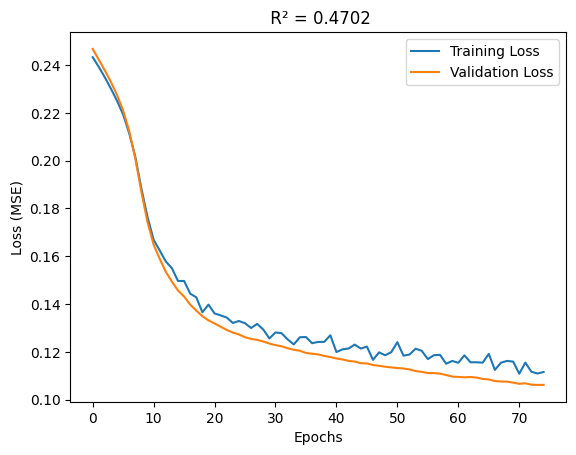

In [ ]:
# Define the LSTM model with 3-4 layers
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Set a custom learning rate for the Adam optimizer
learning_rate = 0.00005  # Adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mse')

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=75,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    verbose=1
)

plot_model_results(history, model, X_test_reshaped, y_test)

#6. Increase Complexity

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.2149 - val_loss: 0.2322
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2080 - val_loss: 0.2175
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1641 - val_loss: 0.2075
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1426 - val_loss: 0.1966
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1430 - val_loss: 0.1784
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1428 - val_loss: 0.1579
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1494 - val_loss: 0.1427
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1469 - val_loss: 0.1269
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1223 - val_loss: 0.1172
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1296 - val_loss: 0.1131
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1214 - val_loss: 0.1110
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.

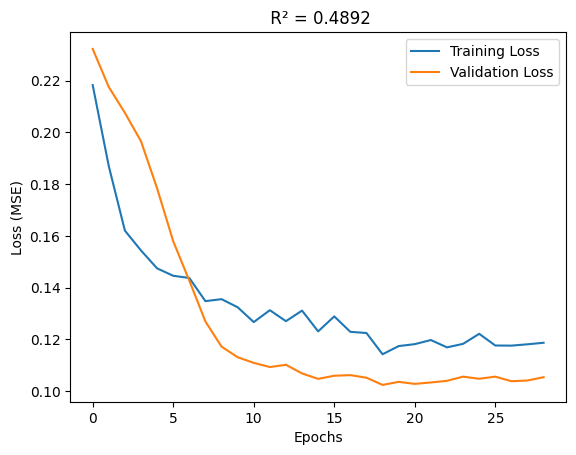

In [ ]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization

# Define the LSTM model with 3-4 layers
model = Sequential([
    Bidirectional(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))),
    Dropout(0.3),
    BatchNormalization(),  # Add batch normalization

    Bidirectional(LSTM(64, activation='relu', return_sequences=True)),
    Dropout(0.3),

    LSTM(32, activation='relu', return_sequences=False),  # No return_sequences for the final LSTM layer
    Dropout(0.3),

    Dense(64, activation='relu'),  # Fully connected layer
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Set a custom learning rate for the Adam optimizer
learning_rate = 0.00005  # Adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping],
    verbose=1
)

plot_model_results(history, model, X_test_reshaped, y_test)